<a href="https://colab.research.google.com/github/Nicordaro/Homework_3/blob/master/HomeWork_3_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Install requirements**

In [0]:
def loss_plot(losses, steps):
  ### FOR MEAN STD PLOT https://stackoverflow.com/questions/22481854/plot-mean-and-standard-deviation
  from scipy import interpolate

  tck,u     = interpolate.splprep([steps,losses],s = 0 )
  xnew,ynew = interpolate.splev( np.linspace( 0, 1, 1000 ), tck,der = 0)

  fig, ax = plt.subplots(figsize=(20,19), facecolor='white')

  plt.rc('font', size=20)
  plt.plot(steps,losses,'.' , xnew ,ynew, label = "accuracy", c='red' )
  ax.set_ylabel("Loss")
  ax.set_xlabel("Steps")
  ax.minorticks_on()
  plt.title("Loss trend")
  plt.yticks(np.arange(0, 2.1, .1))
  plt.xticks(np.arange(0, 180, 10))
  plt.grid(axis='y',which='major', linestyle='-', linewidth='0.5', color='black') 
  plt.grid(axis='y',which='minor', linestyle=':', linewidth='0.5', color='grey')
  for in_i, in_j in zip(steps, losses):  # Plot also the value of the point close to it
    if (in_i-1)%30 ==0 or in_i-1 ==0 or in_i-1==170:
      ax.annotate(str(round(in_j, 5)), xy=(in_i, in_j))

  plt.savefig('test.png', format='png', dpi=300)
  plt.show()

**Import libraries**

In [0]:
import os
import copy
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn
from torch.hub import load_state_dict_from_url
from torch.autograd import Function
import numpy as np
import matplotlib.pyplot as plt


import torchvision
from torchvision import transforms
from torchvision.models import alexnet
from torchvision.datasets import ImageFolder

from PIL import Image
from tqdm import tqdm

**Set Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 7      # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR =  1e-3           # The initial Learning Rate
LR_DANN = 1e-3
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

**Define Data Preprocessing**

In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                 
])

**Prepare Dataset**

In [0]:
# Clone github repository with data
if not os.path.isdir('./Homework3-PACS'):
  !git clone https://github.com/MachineLearning2020/Homework3-PACS

DATA_DIR = 'Homework3-PACS/PACS'

# Read folder for each domain
Arts = ImageFolder(DATA_DIR+"/art_painting", transform=eval_transform)
Cartoons = ImageFolder(DATA_DIR+"/cartoon", transform=train_transform) 
Photos = ImageFolder(DATA_DIR+"/photo", transform=train_transform) 
Sketches = ImageFolder(DATA_DIR+"/sketch", transform=train_transform)

Cloning into 'Homework3-PACS'...
remote: Enumerating objects: 10032, done.
remote: Total 10032 (delta 0), reused 0 (delta 0), pack-reused 10032
Receiving objects: 100% (10032/10032), 174.13 MiB | 13.16 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (9993/9993), done.


**Prepare Dataloaders**

In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
source_dataloader = DataLoader(Photos, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
target_dataloader = DataLoader(Arts, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
test_dataloader = DataLoader(Arts, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

**Netwok implementation**


In [0]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url
from torch.autograd import Function



__all__ = ['AlexNet', 'alexnet']


model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}

class ReverseLayerF(Function):
    # Forwards identity
    # Sends backward reversed gradients
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None


class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

        self.gradientdomain_classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2), #Domain classifier has to tell if the images comes from source or target, so 2 classes
        )

    def forward(self, x, alpha=None):
      features = self.features(x)
    
      # If we pass alpha, we can assume we are training the discriminator
      if alpha is not None:
          # gradient reversal layer (backward gradients will be reversed)
          features = features.view(-1, 256 * 6 * 6) 
          reverse_features = ReverseLayerF.apply(features, alpha)
          # Flatten the features:
          discriminator_output = torch.flatten(reverse_features, 1)
          discriminator_output = self.gradientdomain_classifier(discriminator_output)
          return discriminator_output
      # If we don't pass alpha, we assume we are training with supervision
      else:
          # do something else
          class_outputs = self.avgpool(features)
          # Flatten the features:
          class_outputs = torch.flatten(class_outputs,1)
          class_outputs = self.classifier(class_outputs)
          return class_outputs

def dann(pretrained=False, progress=True, **kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = AlexNet(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['alexnet'],
                                              progress=progress)
        model.load_state_dict(state_dict, strict=False)
        
        model.gradientdomain_classifier[1].weight.data, model.gradientdomain_classifier[1].bias.data = model.classifier[1].weight.data, model.classifier[1].bias.data
    return model

**Prepare Network**

In [0]:
alex_net = torchvision.models.alexnet(pretrained = True)
dann_net = dann(pretrained = True)

alex_net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
dann_net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


**Prepare Training**

In [0]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = alex_net.parameters() # In this case we optimize over all the parameters of AlexNet
dann_parameters_to_optimize = dann_net.parameters()
# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
dann_optimizer = optim.SGD(dann_parameters_to_optimize, lr=LR_DANN, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
dann_scheduler = optim.lr_scheduler.StepLR(dann_optimizer, step_size=STEP_SIZE, gamma=GAMMA)


**Train**

In [0]:
best_loss = 1000
# By default, everything is loaded to cpu
net = alex_net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
best_model = net
cudnn.benchmark # Calling this optimizes runtime

current_step = 0
loss_trend = []
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  #print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  # Iterate over the dataset
  for images, labels in source_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)
    loss_trend.append(loss.item())

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    if loss < best_loss:
      best_loss = loss
      best_model = copy.deepcopy(net)

    current_step += 1

  # Step the scheduler
  scheduler.step() 

Step 0, Loss 2.175123929977417
Step 10, Loss 0.34146201610565186
Step 20, Loss 0.12543107569217682
Step 30, Loss 0.0897255390882492
Step 40, Loss 0.0651407539844513
Step 50, Loss 0.049150750041007996
Step 60, Loss 0.04911500960588455
Step 70, Loss 0.03160706162452698
Step 80, Loss 0.029546232894062996
Step 90, Loss 0.03639266639947891
Step 100, Loss 0.017276545986533165
Step 110, Loss 0.008393230848014355
Step 120, Loss 0.013344641774892807
Step 130, Loss 0.016255728900432587
Step 140, Loss 0.009040366858243942
Step 150, Loss 0.01773073896765709
Step 160, Loss 0.02077694982290268
Step 170, Loss 0.014091924764215946


**Test**

In [0]:
net = best_model
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(Arts))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 8/8 [00:06<00:00,  1.16it/s]

Test Accuracy: 0.5107421875


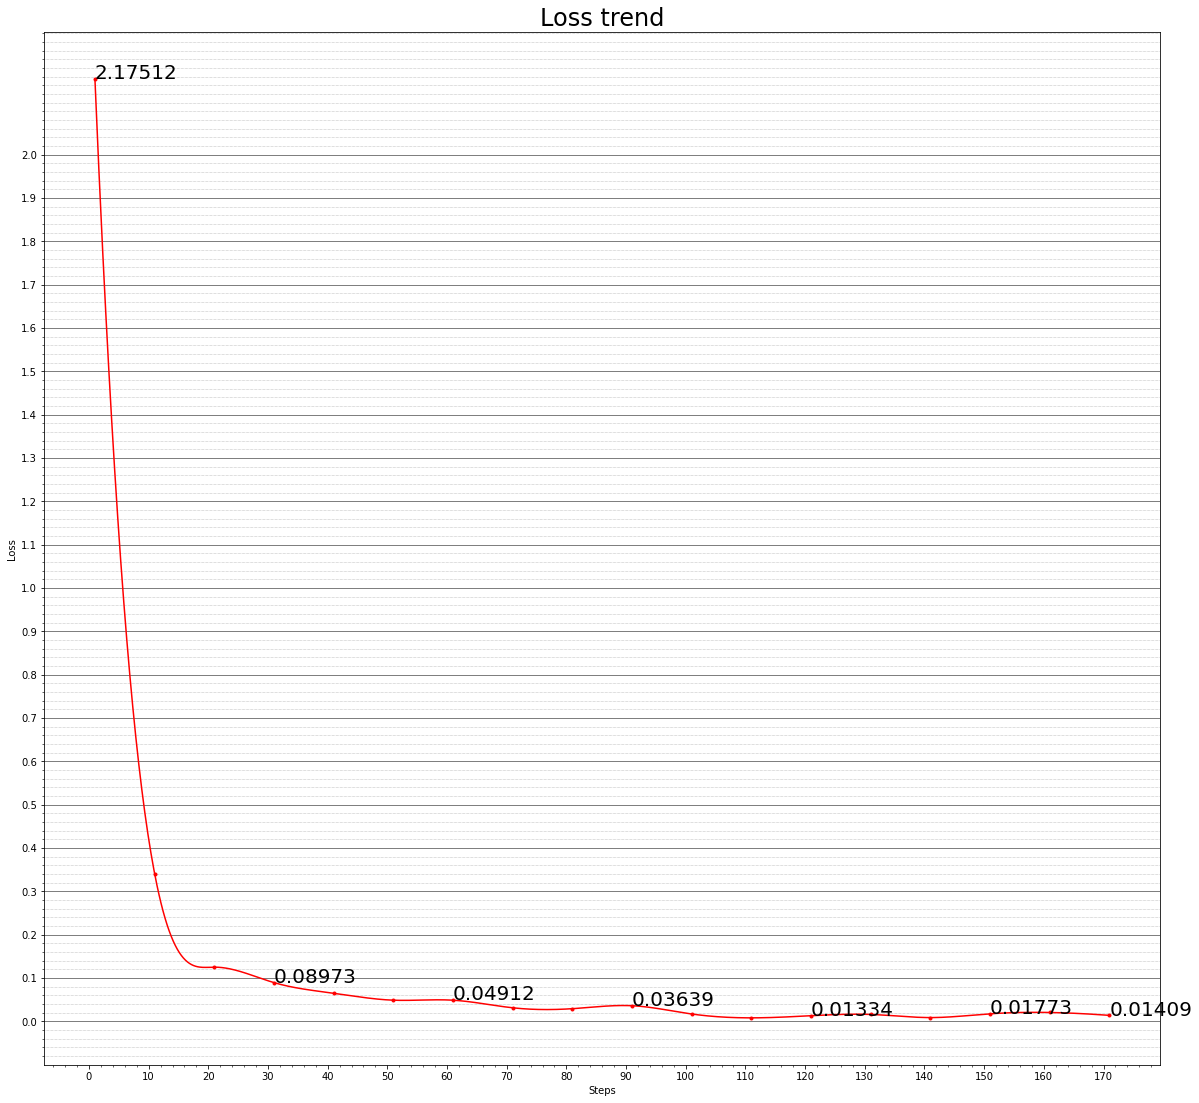

In [0]:
steps = np.arange(1,181, 1)
loss_plot(loss_trend[::10], steps[::10])

**Implement DANN**

_TRAIN_


In [0]:
ALPHA = 0.09
# By default, everything is loaded to cpu
net = dann_net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

loss1_trend=[]
loss2_trend=[]
loss3_trend=[]

current_step = 0
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  #print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, dann_scheduler.get_lr()))

  # Iterate over the dataset
  for source_image in tqdm(source_dataloader):
    # Bring data over the device of choice

    target_image = next(iter(target_dataloader))
    source_imgs, source_lbls = source_image
    target_imgs, target_lbls = target_image

    zeros = torch.zeros(source_lbls.shape, dtype=torch.long)
    ones = torch.ones(target_lbls.shape, dtype=torch.long)
    
    source_imgs = source_imgs.to(DEVICE)
    target_imgs = target_imgs.to(DEVICE)
    source_lbls = source_lbls.to(DEVICE)
    zeros = zeros.to(DEVICE)
    ones = ones.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    dann_optimizer.zero_grad() # Zero-ing the gradients

    outputs = net(source_imgs)
    loss_1 = criterion(outputs, source_lbls)
    loss_1.backward()

    outputs = net(source_imgs, ALPHA)
    loss_2 = criterion(outputs, zeros)
    loss_2.backward()

    outputs = net(target_imgs, ALPHA)
    loss_3 = criterion(outputs, ones)
    loss_3.backward()

    loss1_trend.append(loss_1.item())
    loss2_trend.append(loss_2.item())
    loss3_trend.append(loss_3.item())

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss1 {}, Loss2 {}, Loss3 {}'.format(current_step, loss_1.item(),loss_2.item(),loss_3.item()))
    # Compute gradients for each layer and update weights
    dann_optimizer.step() # update weights based on accumulated gradients

    current_step += 1

  # Step the scheduler
  dann_scheduler.step()

 17%|█▋        | 1/6 [00:08<00:44,  8.85s/it]

Step 0, Loss1 1.9639809131622314, Loss2 0.8871272206306458, Loss3 0.7466468811035156


 83%|████████▎ | 5/6 [00:29<00:06,  6.21s/it]

Step 10, Loss1 0.33895033597946167, Loss2 0.2934238612651825, Loss3 0.16132709383964539


 50%|█████     | 3/6 [00:18<00:20,  6.89s/it]

Step 20, Loss1 0.13257992267608643, Loss2 0.07960864156484604, Loss3 0.18909259140491486


 17%|█▋        | 1/6 [00:10<00:50, 10.10s/it]

Step 30, Loss1 0.09598290920257568, Loss2 0.05480716750025749, Loss3 0.2424221783876419


 83%|████████▎ | 5/6 [00:31<00:06,  6.19s/it]

Step 40, Loss1 0.07644014060497284, Loss2 0.16270564496517181, Loss3 0.15803909301757812


 50%|█████     | 3/6 [00:21<00:24,  8.02s/it]

Step 50, Loss1 0.05946020781993866, Loss2 0.21198852360248566, Loss3 0.08011824637651443


 17%|█▋        | 1/6 [00:10<00:52, 10.59s/it]

Step 60, Loss1 0.06973162293434143, Loss2 0.04343237355351448, Loss3 0.12702134251594543


 83%|████████▎ | 5/6 [00:35<00:07,  7.25s/it]

Step 70, Loss1 0.03636720031499863, Loss2 0.10814905166625977, Loss3 0.05368258059024811


 50%|█████     | 3/6 [00:23<00:25,  8.44s/it]

Step 80, Loss1 0.023427464067935944, Loss2 0.07662323117256165, Loss3 0.12197264283895493


 17%|█▋        | 1/6 [00:09<00:47,  9.43s/it]

Step 90, Loss1 0.03308931738138199, Loss2 0.08276936411857605, Loss3 0.10766209661960602


 83%|████████▎ | 5/6 [00:30<00:06,  6.49s/it]

Step 100, Loss1 0.017445722594857216, Loss2 0.06018948182463646, Loss3 0.12740831077098846


 50%|█████     | 3/6 [00:18<00:20,  6.89s/it]

Step 110, Loss1 0.019436221569776535, Loss2 0.07454022765159607, Loss3 0.129596546292305


 17%|█▋        | 1/6 [00:10<00:51, 10.29s/it]

Step 120, Loss1 0.021931925788521767, Loss2 0.05566048622131348, Loss3 0.1087050810456276


 83%|████████▎ | 5/6 [00:32<00:06,  6.54s/it]

Step 130, Loss1 0.016348715871572495, Loss2 0.14562800526618958, Loss3 0.05683748051524162


 50%|█████     | 3/6 [00:19<00:21,  7.00s/it]

Step 140, Loss1 0.02296951226890087, Loss2 0.04247312992811203, Loss3 0.09091977030038834


 17%|█▋        | 1/6 [00:10<00:53, 10.61s/it]

Step 150, Loss1 0.019031601026654243, Loss2 0.090369313955307, Loss3 0.05316461622714996


 83%|████████▎ | 5/6 [00:33<00:06,  6.81s/it]

Step 160, Loss1 0.014020035974681377, Loss2 0.05312690883874893, Loss3 0.13544799387454987


 50%|█████     | 3/6 [00:20<00:23,  7.70s/it]

Step 170, Loss1 0.00924382358789444, Loss2 0.09483758360147476, Loss3 0.061831530183553696


100%|██████████| 6/6 [00:35<00:00,  5.97s/it]


**Implement DANN**

_TEST_


In [0]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(Arts))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 8/8 [00:06<00:00,  1.24it/s]

Test Accuracy: 0.48974609375


**XDomain Validation w/o DANN**



*TRAIN*


In [0]:
# ALPHAs = np.arange(0.01, 0.11, .02)
# LRs = [0.001, 0.004, 0.01, 0.1, 1]
# Bsize = [128, 256]  
# NUM_EPOCHS = 10
# best_accuracy = 0
# # By default, everything is loaded to cpu

# for ALPHA in ALPHAs:
#   for LR in LRs:
#     for BATCH_SIZE in Bsize:
#       print(f"Setting up a net with: lr={LR}, batch_size={BATCH_SIZE}, alpha={ALPHA}\n")

#       source_dataloader = DataLoader(Photos, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
#       target_dataloader = DataLoader(Cartoons, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
#       test_dataloader = DataLoader(Cartoons, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

      
      
#       #SETTING UP NET
#       dann_net = dann(pretrained = True)
#       dann_net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
#       criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
#       dann_parameters_to_optimize = dann_net.parameters()
#       dann_optimizer = optim.SGD(dann_parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
#       dann_scheduler = optim.lr_scheduler.StepLR(dann_optimizer, step_size=STEP_SIZE, gamma=GAMMA)

#       net = dann_net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

#       cudnn.benchmark # Calling this optimizes runtime

#       current_step = 0
#       # Start iterating over the epochs
#       for epoch in range(NUM_EPOCHS):
#         #print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, dann_scheduler.get_lr()))

#         # Iterate over the dataset
#         for source_image in source_dataloader:
#           # Bring data over the device of choice

#           target_image = next(iter(target_dataloader))
#           source_imgs, source_lbls = source_image
#           target_imgs, target_lbls = target_image

#           zeros = torch.zeros(source_lbls.shape, dtype=torch.long)
#           ones = torch.ones(target_lbls.shape, dtype=torch.long)
          
#           source_imgs = source_imgs.to(DEVICE)
#           target_imgs = target_imgs.to(DEVICE)
#           source_lbls = source_lbls.to(DEVICE)
#           zeros = zeros.to(DEVICE)
#           ones = ones.to(DEVICE)

#           net.train() # Sets module in training mode

#           dann_optimizer.zero_grad() # Zero-ing the gradients

#           outputs = net(source_imgs)
#           loss_1 = criterion(outputs, source_lbls)
#           loss_1.backward()

#           outputs = net(source_imgs, ALPHA)
#           loss_2 = criterion(outputs, zeros)
#           loss_2.backward()

#           outputs = net(target_imgs, ALPHA)
#           loss_3 = criterion(outputs, ones)
#           loss_3.backward()

#           # Log loss
#           if current_step % LOG_FREQUENCY == 0:
#             print('Step {}, Loss1 {}, Loss2 {}, Loss3 {}'.format(current_step, loss_1.item(),loss_2.item(),loss_3.item()))
#           # Compute gradients for each layer and update weights
#           dann_optimizer.step() # update weights based on accumulated gradients

#           current_step += 1

#         # Step the scheduler
#         dann_scheduler.step()
      
#       net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
#       net.train(False) # Set Network to evaluation mode

#       running_corrects = 0
#       for images, labels in test_dataloader:
#         images = images.to(DEVICE)
#         labels = labels.to(DEVICE)

#         # Forward Pass
#         outputs = net(images)

#         # Get predictions
#         _, preds = torch.max(outputs.data, 1)

#         # Update Corrects
#         running_corrects += torch.sum(preds == labels.data).data.item()

#       # Calculate Accuracy
#       accuracy_cartoon = running_corrects / float(len(Cartoons))

#       print('Test Accuracy on Cartoon: {}'.format(accuracy_cartoon))

#       #Without changing the network
#       #Train photos, test sketch

#       source_dataloader = DataLoader(Photos, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
#       target_dataloader = DataLoader(Sketches, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
#       test_dataloader = DataLoader(Sketches, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

#       #SETTING UP NET
#       dann_net = dann(pretrained = True)
#       dann_net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
#       criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
#       dann_parameters_to_optimize = dann_net.parameters()
#       dann_optimizer = optim.SGD(dann_parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
#       dann_scheduler = optim.lr_scheduler.StepLR(dann_optimizer, step_size=STEP_SIZE, gamma=GAMMA)

#       net = dann_net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

#       cudnn.benchmark # Calling this optimizes runtime

#       current_step = 0
#       # Start iterating over the epochs
#       for epoch in range(NUM_EPOCHS):
#         #print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, dann_scheduler.get_lr()))

#         # Iterate over the dataset
#         for source_image in source_dataloader:
#           # Bring data over the device of choice

#           target_image = next(iter(target_dataloader))
#           source_imgs, source_lbls = source_image
#           target_imgs, target_lbls = target_image

#           zeros = torch.zeros(source_lbls.shape, dtype=torch.long)
#           ones = torch.ones(target_lbls.shape, dtype=torch.long)
          
#           source_imgs = source_imgs.to(DEVICE)
#           target_imgs = target_imgs.to(DEVICE)
#           source_lbls = source_lbls.to(DEVICE)
#           zeros = zeros.to(DEVICE)
#           ones = ones.to(DEVICE)

#           net.train() # Sets module in training mode

#           dann_optimizer.zero_grad() # Zero-ing the gradients

#           outputs = net(source_imgs)
#           loss_1 = criterion(outputs, source_lbls)
#           loss_1.backward()

#           outputs = net(source_imgs, ALPHA)
#           loss_2 = criterion(outputs, zeros)
#           loss_2.backward()

#           outputs = net(target_imgs, ALPHA)
#           loss_3 = criterion(outputs, ones)
#           loss_3.backward()

#           # Log loss
#           if current_step % LOG_FREQUENCY == 0:
#             print('Step {}, Loss1 {}, Loss2 {}, Loss3 {}'.format(current_step, loss_1.item(),loss_2.item(),loss_3.item()))
#           # Compute gradients for each layer and update weights
#           dann_optimizer.step() # update weights based on accumulated gradients

#           current_step += 1

#         # Step the scheduler
#         dann_scheduler.step()
      
#       net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
#       net.train(False) # Set Network to evaluation mode

#       running_corrects = 0
#       for images, labels in test_dataloader:
#         images = images.to(DEVICE)
#         labels = labels.to(DEVICE)

#         # Forward Pass
#         outputs = net(images)

#         # Get predictions
#         _, preds = torch.max(outputs.data, 1)

#         # Update Corrects
#         running_corrects += torch.sum(preds == labels.data).data.item()

#       # Calculate Accuracy
#       accuracy_sketch = running_corrects / float(len(Sketches))

#       print('\nTest Accuracy Sketch: {}'.format(accuracy_sketch))

#       accuracy_avg = (accuracy_sketch + accuracy_cartoon)/2
#       if best_accuracy > accuracy_avg:
#         best_accuracy = accuracy_avg
#         best_params = [LR,BATCH_SIZE,ALPHA]
#       print('\nTest Accuracy Average: {}'.format(accuracy_avg))

In [0]:
# best_params = [0.04, 128, 0.05]
# print(best_params)

In [0]:
# LR_best = best_params[0]
# BS_best = best_params[1]
# ALPHA_best = best_params[2]

# source_dataloader = DataLoader(Photos, batch_size=BS_best, shuffle=True, num_workers=4, drop_last=True)
# target_dataloader = DataLoader(Arts, batch_size=BS_best, shuffle=True, num_workers=4, drop_last=True)
# test_dataloader = DataLoader(Arts, batch_size=BS_best, shuffle=False, num_workers=4)


# loss1_trend=[]
# loss2_trend=[]
# loss3_trend=[]

# #SETTING UP NET
# dann_net_best = dann(pretrained = True)
# dann_net_best.classifier[6] = nn.Linear(4096, NUM_CLASSES)
# criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
# dann_parameters_to_optimize = dann_net_best.parameters()
# dann_optimizer = optim.SGD(dann_parameters_to_optimize, lr=LR_best, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
# dann_scheduler = optim.lr_scheduler.StepLR(dann_optimizer, step_size=STEP_SIZE, gamma=GAMMA)

# net = dann_net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

# cudnn.benchmark # Calling this optimizes runtime

# current_step = 0
# # Start iterating over the epochs
# for epoch in range(NUM_EPOCHS):
# #print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, dann_scheduler.get_lr()))

#     # Iterate over the dataset
#     for num_el, source_image in source_dataloader:
        
#         tot1=0
#         tot2=0
#         tot3=0
#           # Bring data over the device of choice

#         target_image = next(iter(target_dataloader))
#         source_imgs, source_lbls = source_image
#         target_imgs, target_lbls = target_image

#         zeros = torch.zeros(source_lbls.shape, dtype=torch.long)
#         ones = torch.ones(target_lbls.shape, dtype=torch.long)

#         source_imgs = source_imgs.to(DEVICE)
#         target_imgs = target_imgs.to(DEVICE)
#         source_lbls = source_lbls.to(DEVICE)
#         zeros = zeros.to(DEVICE)
#         ones = ones.to(DEVICE)

#         net.train() # Sets module in training mode

#         dann_optimizer.zero_grad() # Zero-ing the gradients

#         outputs = net(source_imgs)
#         loss_1 = criterion(outputs, source_lbls)
#         tot1+=loss_1
#         loss_1.backward()

#         outputs = net(source_imgs, ALPHA_best)
#         loss_2 = criterion(outputs, zeros)
#         tot2+=loss_2
#         loss_2.backward()

#         outputs = net(target_imgs, ALPHA_best)
#         loss_3 = criterion(outputs, ones)
#         tot3+=loss_3
#         loss_3.backward()

#         # Log loss
#         if current_step % LOG_FREQUENCY == 0:
#             print('Step {}, Loss1 {}, Loss2 {}, Loss3 {}'.format(current_step, loss_1.item(),loss_2.item(),loss_3.item()))
#         # Compute gradients for each layer and update weights
#         dann_optimizer.step() # update weights based on accumulated gradients

#         current_step += 1

#     loss1_trend.append(loss_1)
#     loss2_trend.append(loss_2) 
#     loss3_trend.append(loss_3) 

# # Step the scheduler
# dann_scheduler.step()

# net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
# net.train(False) # Set Network to evaluation mode

# running_corrects = 0
# for images, labels in test_dataloader:
#     images = images.to(DEVICE)
#     labels = labels.to(DEVICE)

#         # Forward Pass
#     outputs = net(images)

#         # Get predictions
#     _, preds = torch.max(outputs.data, 1)

#         # Update Corrects
#     running_corrects += torch.sum(preds == labels.data).data.item()

#       # Calculate Accuracy
# accuracy_best = running_corrects / float(len(Arts))

# print('\nTest Accuracy Arts after XD: {}'.format(accuracy_best))

In [0]:
# loss1_trend = [0.17374801635742188, 0.1314830183982849, 0.10136518627405167, 0.0921366959810257, 0.04113272577524185, 0.0062138475477695465, 0.025703726336359978, 0.0015649870038032532, 0.011402472853660583, 0.0012216269969940186, 0.004506073892116547, 0.006769582629203796, 0.00040884315967559814, 0.002203267067670822, 0.0008710473775863647, 0.0008120127022266388, 0.013858657330274582, 0.0005325861275196075, 0.0008792951703071594, 0.010212782770395279, 0.007657602429389954, 0.0016020238399505615, 0.0006683245301246643, 0.00038110464811325073, 0.00015410780906677246, 0.00020063668489456177, 0.0011071264743804932, 0.0012451931834220886, 9.332597255706787e-05, 0.0042412132024765015]
# loss2_trend = [0.2155022770166397, 1.4326051473617554, 0.15864960849285126, 0.21605674922466278, 0.3724810481071472, 0.24680110812187195, 0.27164384722709656, 0.13285022974014282, 0.10495393723249435, 0.0527406670153141, 0.03116776794195175, 0.1174980103969574, 0.04898623377084732, 0.054999709129333496, 0.04435326159000397, 0.036153510212898254, 0.09098437428474426, 0.029224302619695663, 0.012637573294341564, 0.03803441673517227, 0.07798570394515991, 0.09009431302547455, 0.055349744856357574, 0.03216855973005295, 0.05383186414837837, 0.005868272390216589, 0.04028680920600891, 0.03200049325823784, 0.05988319590687752, 0.0070512560196220875]
# loss3_trend = [2.9216716289520264, 0.011479237116873264, 0.4099693298339844, 0.16488388180732727, 0.05375067889690399, 0.10554511845111847, 0.06133623421192169, 0.054543402045965195, 0.15832318365573883, 0.1394714117050171, 0.031028179451823235, 0.05170631781220436, 0.06556188315153122, 0.07217944413423538, 0.04782396927475929, 0.05948096513748169, 0.015436681918799877, 0.03199683129787445, 0.05964517593383789, 0.01526304055005312, 0.009227781556546688, 0.005253888666629791, 0.00945344939827919, 0.041247159242630005, 0.1071583479642868, 0.07670421898365021, 0.05070803686976433, 0.021508805453777313, 0.024618403986096382, 0.059836599975824356]


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


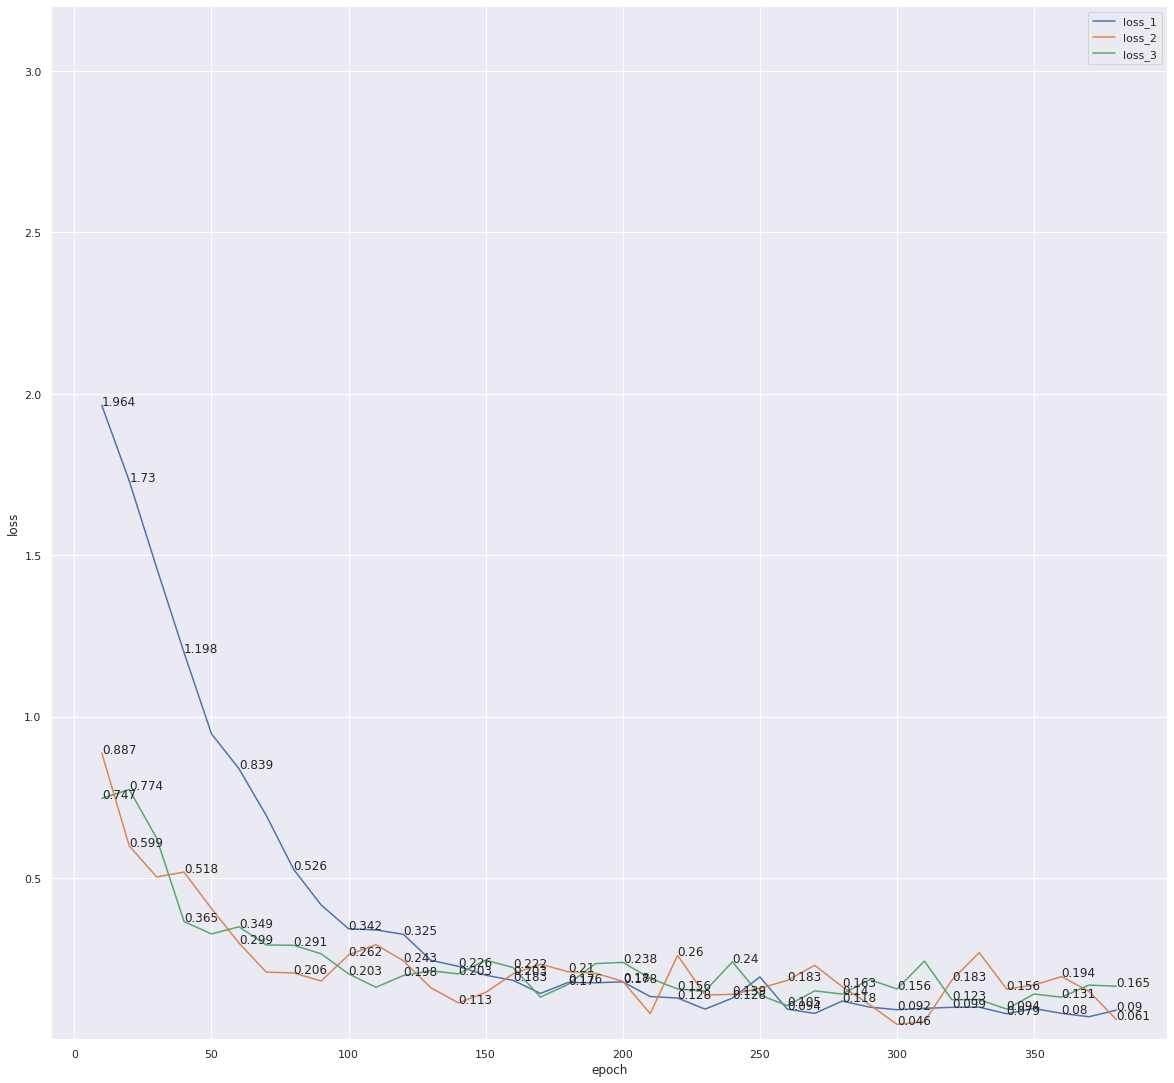

In [0]:
import seaborn as sns
import pandas as pd
import numpy as np

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,19), facecolor='white')
epochs = np.arange(10, 390, 10)
datas_1 = pd.DataFrame(list(zip(epochs, loss1_trend)), columns =['epoch', 'loss'])
datas_2 = pd.DataFrame(list(zip(epochs, loss2_trend)), columns =['epoch', 'loss'])
datas_3 = pd.DataFrame(list(zip(epochs, loss3_trend)), columns =['epoch', 'loss'])
ax = sns.lineplot(x="epoch", y="loss",
                  markers=True, dashes=False, data=datas_1)
ax = sns.lineplot(x="epoch", y="loss",
                  markers=True, dashes=False, data=datas_2)
ax = sns.lineplot(x="epoch", y="loss",
                  markers=True, dashes=False, data=datas_3)
for epoch, value in zip(epochs, loss1_trend):  # Plot also the value of the point close to it
  if epoch%20==0 or epoch==10:
    ax.annotate(str(round(value, 3)), xy=(epoch, value))
for epoch, value in zip(epochs, loss2_trend):  # Plot also the value of the point close to it
  if epoch%20==0 or epoch==10:
    ax.annotate(str(round(value, 3)), xy=(epoch, value))
for epoch, value in zip(epochs, loss3_trend):  # Plot also the value of the point close to it
  if epoch%20==0 or epoch==10:
    ax.annotate(str(round(value, 3)), xy=(epoch, value))

plt.ylim([0.00008, 3.2])
plt.gca().legend(('loss_1','loss_2','loss_3'))